This notebook shows how to use a simple technique involving word counts to build a model that predicts the sentiment of wine reviews (positive vs negative). The review dataset comes from [this Kaggle page](https://www.kaggle.com/zynicide/wine-reviews) and includes the text of about 150,000 wine reviews from [WineEnthusiast](https://www.winemag.com/).

We'll start by loading the data into a Pandas dataframe. First, let's import pandas:

In [1]:
import pandas as pd

Pandas has a convenient method for creating a dataframe from a csv file:

In [2]:
df = pd.read_csv('winemag-data_first150k.csv')

Let's take a look at the first few rows of the dataframe:

In [3]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


There is a lot of information in this dataframe. The 'description' column is the key to an NLP project because it contains blocks of text that we can process. The 'points' and 'price' columns contain numeric values that could be used in a regression problem, mapping text to continuous values. The rest of the columns contain text labels that could be used in a categorization project, mapping text to various labels. For example, we could predict a wine's variety or the country it came from. 

But we're actually going to use the 'points' column to create a binary classification problem (predicting between two possible categories). The first step is to get rid of the columns we don't need. We can do this by redefining the dataframe with only the columns we want to keep:

In [4]:
# create a new dataframe containing only these two columns from the old dataframe
df = df[['description', 'points']]

And this is what the dataframe now looks like:

In [5]:
df.head()

,description,points
0,This tremendous 100% varietal wine hails from ...,96
1,"Ripe aromas of fig, blackberry and cassis are ...",96
2,Mac Watson honors the memory of a wine once ma...,96
3,"This spent 20 months in 30% new French oak, an...",96
4,"This is the top wine from La Bégude, named aft...",95


It would be nice if we could see the full text of the reviews. They are not very long so they shouldn't take up too much space on the page. We can do this by changing a display setting in Pandas:

In [6]:
pd.set_option('display.max_colwidth', -1)

And now we can see the full reviews:

In [7]:
df.head()

,description,points
0,"This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.",96
1,"Ripe aromas of fig, blackberry and cassis are softened and sweetened by a slathering of oaky chocolate and vanilla. This is full, layered, intense and cushioned on the palate, with rich flavors of chocolaty black fruits and baking spices. A toasty, everlasting finish is heady but ideally balanced. Drink through 2023.",96
2,"Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.",96
3,"This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded with dark chocolate and espresso. Drink now through 2032.",96
4,"This is the top wine from La Bégude, named after the highest point in the vineyard at 1200 feet. It has structure, density and considerable acidity that is still calming down. With 18 months in wood, the wine has developing an extra richness and concentration. Produced by the Tari family, formerly of Château Giscours in Margaux, it is a wine made for aging. Drink from 2020.",95


Now that we've focused in on the important columns, we can work on creating a new column for sentiment based on the values in the 'points' column. I could try to predict the exact point rating for each review, but I'd rather turn this into a simpler problem. Let's look at the range of values in the 'points' column:

In [8]:
# show statistics about the 'points' column
df['points'].describe()

count    150930.000000
mean     87.888418    
std      3.222392     
min      80.000000    
25%      86.000000    
50%      88.000000    
75%      90.000000    
max      100.000000   
Name: points, dtype: float64

We can see that the point values range from 80 to 100 and have a mean of about 88. Most of the reviews have point ratings around that middle value, as we can see from a histogram of the values:

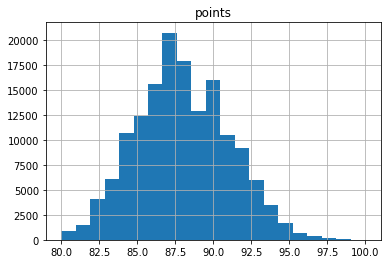

In [11]:
# we need matplotlib to see the histogram
import matplotlib.pyplot as plt
# use 21 bins because there are 21 possible values (80-100)
hist = df.hist(column='points', bins=21)

The simplest way to split these into 'good' and 'bad' categories would be to sort them ascending by point value and mark the first half as 'bad' and the last half as 'good'. But most of the reviews are somewhere in the middle, making them hard to distinguish. It's not that interesting to predict exactly how average a wine will be, so let's just look at the extremes of 'very bad' and 'very good'. 

We can choose a number of reviews to take from both ends of the spectrum. Let's look at the total number of reviews:

In [12]:
len(df)

150930

Before we go further, let's do a bit of cleaning to make sure we don't have any duplicate entries in the data. There's no reason to count the same review more than once:

In [13]:
# remove any duplicate rows
df = df.drop_duplicates()

And now we can check the length of the dataframe again to see if we removed anything:

In [14]:
len(df)

97831

It looks like there were a lot of duplicates in the data (over a third of the total rows). Now we know that each review is unique.

There are about 100,000 reviews, so if we take 10,000 from each end, we will probably get reviews with meaningful sentiment (extremely positive or negative).

Let's sort the data by the 'points' column:

In [15]:
df = df.sort_values('points')

Now the worst reviews will be at the top, as we can see by looking at the first few rows:

In [16]:
df.head()

,description,points
19353,"Barely acceptable. Dry, harsh and vegetal.",80
140172,"Murky and damp smelling, with buttery strawberry flavors. Peppery and dry, with a raw, thin mouthfeel. Acceptable at a base level.",80
140173,"Unpleasantly sharp in acids, and burdened with residual sugar, this is a hard wine to like.",80
140174,"Despite 15-1/2 percent alcohol, this wine still has residual sugar! Think what the brix must have been at harvest. Drinks like a Port, which is a major fault for a dry table wine. Tasted twice, with consistent results.",80
140175,"Heavily toasted, with lemon and burnt-toast aromas. The palate is extremely lemony and short of any lushness normally associated with Merlot. Has color but no ripeness. Proof that Casablanca is not great for Bordeaux varieties.",80


And here are the best reviews, at the bottom:

In [17]:
df.tail()

,description,points
19354,"In a stunning lineup of Cayuse Syrahs, the En Chamberlin wins by a nose. It's smooth and silky, with a tongue-bending blend of flavors that include blood and iron, umami and salt, at first overtaking the pure fruit, but adding tremendous depth and power. The endless finish unfolds into a wine with exotic spices and complex layering.",100
19355,"Not a Cellar Selection in the traditional sense of requiring additional aging, this venerable wine (it contains some material over 100 years old) is ready to drink now, but should hold in the bottle indefinitely. It's dark coffee-brown, with delectable aromas of rancio, pressed flowers, molasses and honey, yet despite enormous concentration avoids excessive weight. Amazingly complex and fresh on the neverending finish.",100
24151,"A perfect wine from a classic vintage, the 2007 Masseto (100% Merlot from a 17-acre vineyard of the same name) opens with an unabashedly opulent bouquet of delicious blackberry, cherry, chocolate, vanilla, exotic spice and cinnamon. Masseto excels both in terms of quality of fruit and winemaking and delivers plush, velvety tannins and an extra long, supple finish. It will make a special and valuable collection to your cellar.",100
98647,"A spectacular Pinot Noir, but a very young one, and extremely dry. It's a wine of great structure, with rich acids and tannins framing extraordinarily complex flavors of grilled cherries, strawberries and raspberries, with complicating notes of cola, pomegranates, orange zest, anise, dusty Asian spices and smoky sandalwood. A truly great Pinot Noir from a great vintage that needs time in the bottle to express itself. The vineyard, which is owned by the winery, is only 19 acres, planted to an array of newer and older clones. Best after 2013, if you can keep your hands off.",100
92916,"A perfect score has to be considered in the context of its region. Shafer's 2004 Hillside Select is tremendous as a Napa Valley Cabernet Sauvignon that competes with its peers at the highest levels. It's always a fabulous wine, but in warm 2004, Shafer's amphitheater vineyard sheltered the grapes, ripening them to perfection yet protecting the “iron fist in a velvet glove” structure that André Tchelistcheff defined as Stags Leap. This 100% Cabernet is tremendous in cassis, black currant and mocha flavors, and the 100% new French oak provides perfect additions of smoke and caramel. It's soft and gorgeous enough to drink now, and should age well in a cool cellar for the next 20 years.",100


Now let's create our sentiment labels in a new column called 'sentiment', with 0 for negative and 1 for positive. We know from before that the average point value is around 88, so let's label everything below 88 as negative and everything 88 and above as positive:

In [18]:
df['sentiment'] = df['points'].apply(lambda points: 0 if points < 88 else 1)

Now the negative reviews are labeled with a 0 for sentiment:

In [19]:
df.head()

,description,points,sentiment
19353,"Barely acceptable. Dry, harsh and vegetal.",80,0
140172,"Murky and damp smelling, with buttery strawberry flavors. Peppery and dry, with a raw, thin mouthfeel. Acceptable at a base level.",80,0
140173,"Unpleasantly sharp in acids, and burdened with residual sugar, this is a hard wine to like.",80,0
140174,"Despite 15-1/2 percent alcohol, this wine still has residual sugar! Think what the brix must have been at harvest. Drinks like a Port, which is a major fault for a dry table wine. Tasted twice, with consistent results.",80,0
140175,"Heavily toasted, with lemon and burnt-toast aromas. The palate is extremely lemony and short of any lushness normally associated with Merlot. Has color but no ripeness. Proof that Casablanca is not great for Bordeaux varieties.",80,0


And the positive reviews are labeled with a 1:

In [20]:
df.tail()

,description,points,sentiment
19354,"In a stunning lineup of Cayuse Syrahs, the En Chamberlin wins by a nose. It's smooth and silky, with a tongue-bending blend of flavors that include blood and iron, umami and salt, at first overtaking the pure fruit, but adding tremendous depth and power. The endless finish unfolds into a wine with exotic spices and complex layering.",100,1
19355,"Not a Cellar Selection in the traditional sense of requiring additional aging, this venerable wine (it contains some material over 100 years old) is ready to drink now, but should hold in the bottle indefinitely. It's dark coffee-brown, with delectable aromas of rancio, pressed flowers, molasses and honey, yet despite enormous concentration avoids excessive weight. Amazingly complex and fresh on the neverending finish.",100,1
24151,"A perfect wine from a classic vintage, the 2007 Masseto (100% Merlot from a 17-acre vineyard of the same name) opens with an unabashedly opulent bouquet of delicious blackberry, cherry, chocolate, vanilla, exotic spice and cinnamon. Masseto excels both in terms of quality of fruit and winemaking and delivers plush, velvety tannins and an extra long, supple finish. It will make a special and valuable collection to your cellar.",100,1
98647,"A spectacular Pinot Noir, but a very young one, and extremely dry. It's a wine of great structure, with rich acids and tannins framing extraordinarily complex flavors of grilled cherries, strawberries and raspberries, with complicating notes of cola, pomegranates, orange zest, anise, dusty Asian spices and smoky sandalwood. A truly great Pinot Noir from a great vintage that needs time in the bottle to express itself. The vineyard, which is owned by the winery, is only 19 acres, planted to an array of newer and older clones. Best after 2013, if you can keep your hands off.",100,1
92916,"A perfect score has to be considered in the context of its region. Shafer's 2004 Hillside Select is tremendous as a Napa Valley Cabernet Sauvignon that competes with its peers at the highest levels. It's always a fabulous wine, but in warm 2004, Shafer's amphitheater vineyard sheltered the grapes, ripening them to perfection yet protecting the “iron fist in a velvet glove” structure that André Tchelistcheff defined as Stags Leap. This 100% Cabernet is tremendous in cassis, black currant and mocha flavors, and the 100% new French oak provides perfect additions of smoke and caramel. It's soft and gorgeous enough to drink now, and should age well in a cool cellar for the next 20 years.",100,1


Now let's take the first 10,000 rows (terrible reviews) and last 10,000 rows (amazing reviews) and put them together to create our sentiment analysis dataset:

In [21]:
df = pd.concat([df[:10000], df[-10000:]])

There should now be 20,000 rows. Let's make sure:

In [22]:
len(df)

20000

Great. But we still have a column we don't need anymore: the 'points' column, which is still there between 'description' and 'sentiment':

In [23]:
df.head()

,description,points,sentiment
19353,"Barely acceptable. Dry, harsh and vegetal.",80,0
140172,"Murky and damp smelling, with buttery strawberry flavors. Peppery and dry, with a raw, thin mouthfeel. Acceptable at a base level.",80,0
140173,"Unpleasantly sharp in acids, and burdened with residual sugar, this is a hard wine to like.",80,0
140174,"Despite 15-1/2 percent alcohol, this wine still has residual sugar! Think what the brix must have been at harvest. Drinks like a Port, which is a major fault for a dry table wine. Tasted twice, with consistent results.",80,0
140175,"Heavily toasted, with lemon and burnt-toast aromas. The palate is extremely lemony and short of any lushness normally associated with Merlot. Has color but no ripeness. Proof that Casablanca is not great for Bordeaux varieties.",80,0


We have the sentiment label now, so the points label isn't needed. Let's drop it from the dataframe:

In [24]:
df = df.drop('points', axis=1)

And check that it's gone now:

In [25]:
df.head()

,description,sentiment
19353,"Barely acceptable. Dry, harsh and vegetal.",0
140172,"Murky and damp smelling, with buttery strawberry flavors. Peppery and dry, with a raw, thin mouthfeel. Acceptable at a base level.",0
140173,"Unpleasantly sharp in acids, and burdened with residual sugar, this is a hard wine to like.",0
140174,"Despite 15-1/2 percent alcohol, this wine still has residual sugar! Think what the brix must have been at harvest. Drinks like a Port, which is a major fault for a dry table wine. Tasted twice, with consistent results.",0
140175,"Heavily toasted, with lemon and burnt-toast aromas. The palate is extremely lemony and short of any lushness normally associated with Merlot. Has color but no ripeness. Proof that Casablanca is not great for Bordeaux varieties.",0


Ok. Now that the data is all set up, we can start doing some NLP. But before we start learning patterns in the data, let's split it into train and test sets so we can have a way to test our predictions on unseen data. 

Let's use [scikit-learn](https://scikit-learn.org/) to create our train and test sets:

In [26]:
from sklearn.model_selection import train_test_split
# use 10% of the data for the test set
df_train, df_test = train_test_split(df, test_size=0.1)

90% of the data should be in the training set, and 90% of 20,000 is 18,000. Let's see if that's what we have:

In [27]:
len(df_train)

18000

Good. And 10% of the data (2000 rows) should be in the testing set:

In [28]:
len(df_test)

2000

Everything looks good so far. 

At this point, the train and test sets are references to the full dataset. Since we're going to be adding some columns to them soon, let's make each one own its data. We can do this by having each refer to a copy of the data it's referencing:

In [29]:
df_train = df_train.copy()
df_test = df_test.copy()

Now let's set the test set aside for a while and do some processing with the train set. Let's talk a bit about the approach we'll use for predicting sentiment.

We're going to predict whether a review is positive or negative based on the presence of certain words in the review text. We're not going to look at the order of words, or how close together they are. We'll hope that the mere presence of certain words will be enough to predict positivity or negativity. But how do we know which words mean 'good' and which mean 'bad'? And how much weight do we give each word in making the prediction when there are both positive and negative words in the same review?

Let's look at this negative review from the training set:

In [31]:
negative_review = df_train.loc[68723]
negative_review['description']

'Floral notes mix with heady aromas of red berry and clay. This wine is soft and dry in the mouth but seems a bit hollow, despite delivering some nice chalky berry flavors that turn to plum on the finish. Imported by Cape Wine Ventures.'

I'm not a domain expert (I don't know much about wine terminology) so I'm not sure if 'dry' and 'chalky' are generally favorable descriptions. 'Floral' sounds positive, but this is a negative review, so my own guesses about which terms are positive or negative are probably not reliable. The only word that stands out as negative is 'hollow', and maybe 'but' and 'despite' imply that something negative came either before or after.

Let's take a look at a positive review:

In [32]:
positive_review = df_train.loc[128211]
positive_review['description']

"Excelencia is a great wine that offers a lot of character beyond just bold fruit and body. This is by far the best El Albar that the Lurtons have made; it features citrus peel, sexy berry fruit and baking spices on the nose, and then sweet berry, black plum, spice and warmth on the palate. It's powerful as a Toro wine should be, but not tannic or harsh. A monster with a smile; drink now and over the next 5–8 years."

This review has some obviously positive words like 'great' and 'best'. It also has the word 'harsh', but after the modifer 'not', which we wouldn't realize when looking only at the presence of individual words. There are more positive-seeming words than negative ones, though, which our prediction method should take into account. Both reviews have the word 'berry', so this doesn't seem to indicate negativity or positivity.

However we deal with each word, we first need to break down each review into a list of words. We'll start by defining a 'tokenize' function to break a string into a list of words:

In [33]:
import re
def tokenize(description):
    return [token for token in re.split('\W+', description.lower()) if token]

Let's try it on the positive review that we were just looking at:

In [34]:
tokenize(df_train.loc[128211]['description'])[:10]

['excelencia', 'is', 'a', 'great', 'wine', 'that', 'offers', 'a', 'lot', 'of']

Now let's create a new column in the training dataframe that does this for each entry:

In [35]:
df_train['tokens'] = df_train['description'].apply(tokenize)

Here's what the dataframe looks like now:

In [36]:
df_train.head()

,description,sentiment,tokens
20749,"Here's a simple, soft little Bordeaux blend. Based on Cabernet Sauvignon, it offers pleasant flavors of blackberries and oak.",0,"[here, s, a, simple, soft, little, bordeaux, blend, based, on, cabernet, sauvignon, it, offers, pleasant, flavors, of, blackberries, and, oak]"
42677,"A terrific Cabernet marked by the superbly ripe, fine tannins and classic blackberry and black currant fruit Napa so routinely delivers. Fully dry, it feels rich and full-bodied and important in the mouth, a wine to drink with fine foods and linger over as it breathes in the glass. Good now, after a brief decant.",1,"[a, terrific, cabernet, marked, by, the, superbly, ripe, fine, tannins, and, classic, blackberry, and, black, currant, fruit, napa, so, routinely, delivers, fully, dry, it, feels, rich, and, full, bodied, and, important, in, the, mouth, a, wine, to, drink, with, fine, foods, and, linger, over, as, it, breathes, in, the, glass, good, now, after, a, brief, decant]"
35098,"Aged 100% in new wood, this is a wine produced as a joint venture between California vintner Paul Hobbs and Cahors producer Bertrand Vigouroux. It is a major, powerful statement, rich and dense. The texture smoothes out the natural structure of Cahors Malbec to give a silky wine, the tannins in suspension in the black plum fruits. It will be better from 2017.",1,"[aged, 100, in, new, wood, this, is, a, wine, produced, as, a, joint, venture, between, california, vintner, paul, hobbs, and, cahors, producer, bertrand, vigouroux, it, is, a, major, powerful, statement, rich, and, dense, the, texture, smoothes, out, the, natural, structure, of, cahors, malbec, to, give, a, silky, wine, the, tannins, in, suspension, in, the, black, plum, fruits, it, will, be, better, from, 2017]"
112858,"Given the high level at which Rioja is running these days, this green wine with aromas of pole beans and tobacco ash just isn't up to standards. Balance and elegance are nowhere to be found.",0,"[given, the, high, level, at, which, rioja, is, running, these, days, this, green, wine, with, aromas, of, pole, beans, and, tobacco, ash, just, isn, t, up, to, standards, balance, and, elegance, are, nowhere, to, be, found]"
142923,"This may well be the best Riesling being made in Washington at the moment. Off-dry and very lightly carbonated, it explodes with a bouquet of flower flavors that hit you with lilac, citrus blossom, talcum powder and more. Lively and tight, the flavors gather strength and concentration as they move through a myriad of pretty fruits, finally resolving in a long, slightly honeyed finish. A masterful effort.",1,"[this, may, well, be, the, best, riesling, being, made, in, washington, at, the, moment, off, dry, and, very, lightly, carbonated, it, explodes, with, a, bouquet, of, flower, flavors, that, hit, you, with, lilac, citrus, blossom, talcum, powder, and, more, lively, and, tight, the, flavors, gather, strength, and, concentration, as, they, move, through, a, myriad, of, pretty, fruits, finally, resolving, in, a, long, slightly, honeyed, finish, a, masterful, effort]"


Now we can use the new 'tokens' column to create a lexicon (a set of all the unique words used in the dataset):

In [37]:
lexicon = set([token for review in df_train['tokens'] for token in review])

We can see how many unique words were used in the full set of reviews:

In [38]:
len(lexicon)

16049

We need to create a 'positivity' rating for each of those words, and there are a lot of them. Doing it manually would take a really long time. But using some word counting and simple math, we can have the computer do it much faster.

Now I'll explain the approach. Our training set has a roughly equal number of positive and negative reviews. For each word in the lexicon we just made, we can count how many times it appears in the full set of positive reviews and how many times it appears in the negative reviews. Then we can make a list of ratios, dividing positive occurances by negative occurances of each word. If a word appears much more in positive reviews than in negative reviews, its presence in any given review indicates that the review will be positive. 

Let's create this list of positivity scores for each word. First we need to have a way to reference the set of positive reviews and the set of negative reviews from the training data:

In [39]:
negative = df_train[df_train['sentiment']==0]
positive = df_train[df_train['sentiment']==1]

Now we can create separate word counts for each category using python's Counter class:

In [40]:
from collections import Counter
negative_counts = Counter(token for review in negative['tokens'] for token in review)
positive_counts = Counter(token for review in positive['tokens'] for token in review)

We can look at the most common words in each category:

In [41]:
negative_counts.most_common(10)

[('and', 19522),
 ('the', 11508),
 ('a', 9668),
 ('with', 7718),
 ('of', 7072),
 ('flavors', 5184),
 ('this', 4904),
 ('is', 4874),
 ('it', 4593),
 ('wine', 3971)]

In [42]:
positive_counts.most_common(10)

[('and', 27589),
 ('the', 20432),
 ('a', 14133),
 ('of', 13924),
 ('with', 9294),
 ('is', 9239),
 ('this', 8605),
 ('it', 8518),
 ('wine', 7331),
 ('in', 6005)]

You'll notice that none of these most common words seem very representative of their respective categories. These word counts aren't much help on their own. The important part is the next step, where we'll take the ratio of positive to negative counts for each word. We'll call this ratio 'positivity':

In [43]:
positivity = {token: (positive_counts[token]+1)/(negative_counts[token]+1) for token in lexicon}

Let's test these positivity scores to see if they make sense. Strongly positive words should have large numbers and strongly negative words should have very small numbers:

In [44]:
positivity['amazing']

45.0

That makes sense. What about a negative word?

In [45]:
positivity['harsh']

0.008438818565400843

The positivity scores are meaningful. Let's put all of this word count data into a new dataframe:

In [46]:
df_tokens = pd.DataFrame({'token': list(lexicon)})
df_tokens['positive_count'] = df_tokens['token'].apply(lambda token: positive_counts[token])
df_tokens['negative_count'] = df_tokens['token'].apply(lambda token: negative_counts[token])
df_tokens['positivity'] = df_tokens['token'].apply(lambda token: positivity[token])

Let's sort this token dataframe by positivity ascending to see the most negative words:

In [47]:
df_tokens.sort_values('positivity').head(10)

,token,positive_count,negative_count,positivity
7543,watery,0,160,0.006211
14543,harsh,1,236,0.008439
5850,bland,0,116,0.008547
11684,dilute,0,102,0.009709
13610,pickled,0,101,0.009804
13689,vegetal,2,295,0.010135
14696,acceptable,0,91,0.010870
13557,everyday,1,169,0.011765
13874,weedy,0,84,0.011765
13884,canned,0,77,0.012821


These are all understandably negative words. I'm not even sure what 'canned' means in reference to wine, but that's ok. The math says it's a negative word, so I don't need to understand why. It's nice to see that even the worst wines are 'acceptable', though. 

And now we can see the most positive words by sorting by positivity descending:

In [48]:
df_tokens.sort_values('positivity', ascending=False).head(10)

,token,positive_count,negative_count,positivity
9575,2020,342,0,343.0
13706,2018,283,0,284.0
7155,94,255,0,256.0
1818,92,186,0,187.0
3431,decade,181,0,182.0
12986,2025,170,0,171.0
9443,barolo,153,0,154.0
11980,93,146,0,147.0
9912,2013,130,0,131.0
12866,2030,122,0,123.0


That's weird, right? The most positive words are mostly numbers (years, specifically). I wouldn't have thought a year could have so much positive sentiment, but that's why we let the computer figure this stuff out instead of me. 

I also don't know what a 'barolo' is, or why the word 'decade' appears so often in the positive rewiews and doesn't appear at all in the negative reviews. It just goes to show that knowledge of wine is not necessary for NLP projects involving wine. 

There's a slight adjustment we can make to the positivity values that will make it easier to compare degrees of positivity and negativity. Right now, a word with positivity of 10 is as positive as a word with positivity .1 is negative. It's hard to immediately see the relation betweens those two values. If we take the log of every positivity score, then its absolute value will describe its degree of sentiment, whether that's negative or positive. 

Let's make that change to the positivity values:

In [49]:
import math
df_tokens['positivity'] = df_tokens['positivity'].apply(lambda positivity: math.log(positivity))

Here's the most positive word:

In [50]:
df_tokens[df_tokens['positivity'] == df_tokens['positivity'].max()]

,token,positive_count,negative_count,positivity
9575,2020,342,0,5.83773


And here's the most negative word:

In [51]:
df_tokens[df_tokens['positivity'] == df_tokens['positivity'].min()]

,token,positive_count,negative_count,positivity
7543,watery,0,160,-5.081404


As you can see, they are roughly equally distant from zero (they have similar absolute values), so now it will be easier to compare positive vs negative words. Another helpful effect of the log function is that it has normalized the values to a smaller range (about -6 to 6) instead of the huge positivity values we had before for some words. 

Now that we have these positivity scores for each word that appears in the reviews, what do we do with them? 

Let's look at that negative review from before:

In [52]:
df_train.loc[68723]['description']

'Floral notes mix with heady aromas of red berry and clay. This wine is soft and dry in the mouth but seems a bit hollow, despite delivering some nice chalky berry flavors that turn to plum on the finish. Imported by Cape Wine Ventures.'

Each of the words in this review now has a positivity rating. Here are the most negative words in the review:

In [53]:
review = df_tokens[df_tokens['token'].isin(df_train.loc[68723]['tokens'])]
review.sort_values('positivity').head()

,token,positive_count,negative_count,positivity
15466,hollow,3,45,-2.442347
14029,cape,0,6,-1.945910
13719,turn,25,93,-1.285198
6067,bit,173,623,-1.277095
7558,nice,61,200,-1.176171


Let's look at a histogram of all the words in the review and their positivity scores:

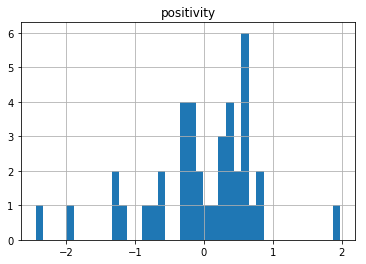

In [54]:
review = df_tokens[df_tokens['token'].isin(df_train.loc[68723]['tokens'])]
hist = review.hist(column='positivity', bins=len(review))

Each bar represents a word in the review. The bar's height is the number of times that word appeared in the review and the bar's x position is the word's positivity value.

Let's look at some statistics for this review:

In [55]:
review['positivity'].describe()

count    40.000000
mean    -0.038796 
std      0.815202 
min     -2.442347 
25%     -0.321213 
50%      0.138840 
75%      0.526604 
max      1.977163 
Name: positivity, dtype: float64

We can see that the review has 40 unique words. The mean positivity score is slightly below zero. This means that if our approach was to take the average positivity rating of all words in a review, we would label this negative review as almost perfectly neutral. 

But -0.050200 is still negative, even if only slightly, so we would correctly classify this review as negative. So maybe this approach of finding the mean positivity of all words in the review will work. 

Let's try the same thing on the positive review from before:

In [56]:
df_train.loc[128211]['description']

"Excelencia is a great wine that offers a lot of character beyond just bold fruit and body. This is by far the best El Albar that the Lurtons have made; it features citrus peel, sexy berry fruit and baking spices on the nose, and then sweet berry, black plum, spice and warmth on the palate. It's powerful as a Toro wine should be, but not tannic or harsh. A monster with a smile; drink now and over the next 5–8 years."

Here are the most positive tokens in the review:

In [57]:
review = df_tokens[df_tokens['token'].isin(df_train.loc[128211]['tokens'])]
review.sort_values('positivity').tail()

,token,positive_count,negative_count,positivity
14254,baking,158,8,2.871680
6416,next,480,22,3.040373
8899,sexy,23,0,3.178054
13920,years,2089,76,3.301114
13705,powerful,734,24,3.380995


And here are the positivity statistics:

In [58]:
review['positivity'].describe()

count    64.000000
mean     0.766739 
std      1.242015 
min     -4.774913 
25%      0.185134 
50%      0.609672 
75%      1.490515 
max      3.380995 
Name: positivity, dtype: float64

This time the average positivity is still near zero, but slightly positive. Another interesting stat is that the most negative word in the review is more negative than the most positive word is positive (look at the min and max values). If we let a single word choose the sentiment prediction, we would get this particular review's prediction wrong. 

Finally, here's a histogram of the words in the positive review:

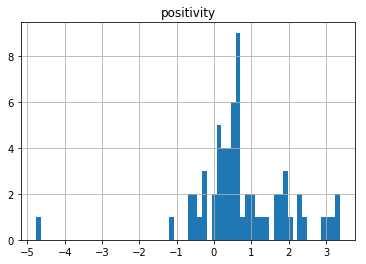

In [59]:
review = df_tokens[df_tokens['token'].isin(df_train.loc[128211]['tokens'])]
hist = review.hist(column='positivity', bins=len(review))

This time there is clearly more weight on the positive side of the scale, so we would predict this review correctly.

Let's test this approach on our training data. We have already 'trained' this model by creating the positivity scores for each token. These were created using the training data, so they should be able to predict the training data well. 

First we need a function to make a prediction given a single review:

In [60]:
def predict(tokens):
    score = df_tokens[df_tokens['token'].isin(tokens)]['positivity'].mean()
    return 1 if score > 0 else 0

Now let's apply this prediction to the whole training dataset and create a new column for the prediction (this might take a little while to run):

In [61]:
df_train['prediction'] = df_train['tokens'].apply(predict)

We can find out how many we predicted correctly like this:

In [62]:
correct = df_train[df_train['sentiment'] == df_train['prediction']]
len(correct)

14185

And here's our accuracy (percentage correct out of total):

In [63]:
len(correct)/len(df_train)

0.7880555555555555

That's not bad. It's a lot better than guessing randomly (which would be around 50% accuracy). 

But that's with the training set. Let's try it on the test set, which hasn't been seen yet:

In [64]:
df_test['tokens'] = df_test['description'].apply(tokenize)

In [65]:
df_test['prediction'] = df_test['tokens'].apply(predict)

In [66]:
correct = df_test[df_test['sentiment'] == df_test['prediction']]
len(correct)

1514

In [67]:
len(correct)/len(df_test)

0.757

It looks like even on data the algorithm hasn't seen yet, it can still predict almost as well as with the training set.

Can we improve the accuracy overall?

Right now, every word in the review is contributing to its prediction score. But most of the words don't tell us much about the sentiment, and so are probably just noise. We need to focus on the signal of the most important words in the review.

What if we only had the highly positive and highly negative words influence the prediction?

Let's create a subset of the tokens dataframe with only the most strongly positive and negative tokens:

In [68]:
strength = 2.8
df_strong = df_tokens[abs(df_tokens['positivity']) > strength]

In [69]:
def predict(tokens):
    score = df_strong[df_strong['token'].isin(tokens)]['positivity'].mean()
    return 1 if score > 0 else 0

In [70]:
df_train['prediction'] = df_train['tokens'].apply(predict)
correct = df_train[df_train['sentiment'] == df_train['prediction']]
len(correct)/len(df_train)

0.9568888888888889

In [71]:
df_test['prediction'] = df_test['tokens'].apply(predict)

In [72]:
correct = df_test[df_test['sentiment'] == df_test['prediction']]
len(correct)/len(df_test)

0.9465

This is doing much better than before. I figured out a good setting for 'strength' by trying out multiple values, just by trial and error. It shows that a single setting like this can have a huge impact on a prediction algorithm. 

Why does this work so well? I'm not really sure. I started with an intuition that some words would appear more often in positive review and some would appear more in negative reviews. Then I figured out a simple equation to act as a measurement of each word's positivity. It happened to work out very well.

Maybe in other datasets this wouldn't work as well. Then I might need to use methods that look at the order of words instead of just their presence. 

It feels efficient to use a simple approach and get a great outcome. Why be more complicated than we need to be? A great thing about this approach is that there is no mystery to how it works and makes decisions. 